In [3]:
import io
import json
from math import sqrt, ceil
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from time import time
from os import system

import tensorflow as tf
import numpy as np
from random import shuffle
import os
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DATA_PATH = '/content/drive/Shareddrives/DriveLaVoitureHAHA/notreIATM/dataset/train_races_mid'
MODEL_PATH = '/content/drive/Shareddrives/DriveLaVoitureHAHA/notreIATM/model/drive'

In [6]:
# IMAGES = DATA_PATH + '/images/dataset.json'
# SAVEMODELPATH = DATA_PATH + '/model/drive'
# MODELFILENAME = 'model_trackmania.h5'

BATCH_SIZE = 10
# NUM_INPUT = 15
# NUM_OUTPUT = 3
# EPOCH = 20

IMAGE_HEIGHT = 540
IMAGE_WIDTH = 960

In [7]:
class Dataset():
    def __init__(self, data_path):
        self.data_path = data_path
        self.dataset_folder_path = data_path + '../../../'
        self.COLUMNS = ['wall0','wall1','wall2','wall3','wall4','wall5','wall6','wall7','wall8','wall9','wall10','wall11','wall12','wall13','speed','turn','go_forward','go_backward']

        with io.open(data_path + '/config.json') as config_file:
            self.config = json.loads(config_file.read())

        with io.open(data_path + '/dataRaw.json') as dataraw_file:
            self.dataraw = [Dataraw(data) for data in json.loads(dataraw_file.read())]

        with io.open(data_path + '/dataset.json') as dataset_file:
            self.framedata = [Framedata(data) for data in json.loads(dataset_file.read())]
        self.framedata_df = self.framedata_to_dataframe()

            
    def display_images(self, lower=0, upper=None, padding=1):
        if upper is None:
            upper = len(self.dataraw)
        n_img = [self.dataset_folder_path + dataraw['imgFilename'] for dataraw in self.dataraw[lower:upper:padding]]
        m = ceil(sqrt(len(n_img)))
        fig, ax = plt.subplots(m, m, figsize=(16,16))
        for i in range(len(n_img)):
            ax = plt.subplot(m, m, i+1)
            ax.set_title(f"Frame {i+1} {n_img[i].split('/')[-1].split('.')[0]}", fontsize=12)
            img_path = n_img[i]
            img = imread(img_path)
            plt.imshow(img)
        plt.plot()
        
    def framedata_to_dataframe(self):
        df = pd.DataFrame([f.to_list() for f in self.framedata], columns=self.COLUMNS)
        df = df.dropna()
        return df

    def get_X_y(self):
        X = self.framedata_df.loc[:,d.COLUMNS[:15]]
        y = self.framedata_df.loc[:,d.COLUMNS[-3:]]
        return (X, y)
      
class Dataraw():
    def __init__(self, jsonData):
        self.imgFilename = jsonData['imgFilename']
        self.target = jsonData['target']
    
    def __repr__(self):
        return f'Dataraw(imgFilename={self.imgFilename}, target={self.target})'

class Framedata():
    def __init__(self, jsonData):
        self.wallDistances = jsonData['wallDistances']
        self.speed = jsonData['speed']
        self.target = jsonData['target']
    
    def __repr__(self):
        return f'Framedata(wallDistances={self.wallDistances}, speed={self.speed}, target={self.target})'
    
    def to_list(self):
        return self.wallDistances + [self.speed] + self.target
        

11068
Found 11068 files belonging to 1 classes.
Using 8855 files for training.


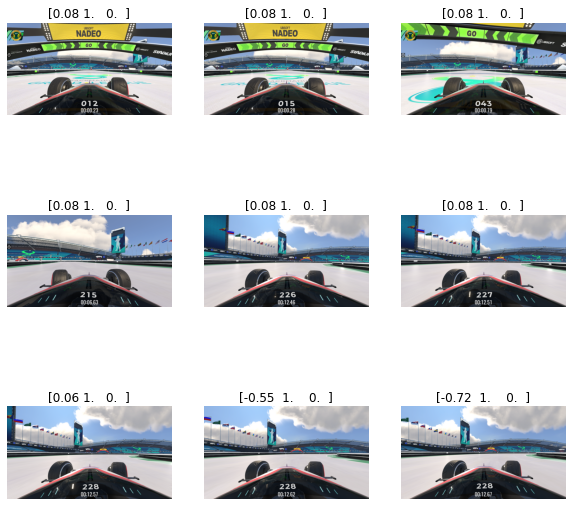

In [8]:
import tensorflow as tf
d = Dataset(DATA_PATH)
d.dataraw.extend([
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}')),
      Dataraw(json.loads('{"imgFilename": "./dataset/drive/keyboard/race1/images/img0.png", "target": [0, 0, 1, 0]}'))
      ])
print(len(d.dataraw))
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  labels=[dataraw.target for dataraw in d.dataraw],
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=False,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

model = Sequential(name="convolution")

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu',
    input_shape=(540,960,3), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))

model.summary()

Model: "convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 540, 960, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 270, 480, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 268, 478, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 134, 239, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 132, 237, 128)     73856     
_________________________________________________________________
dropout (Dropout)            (None, 132, 237, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 66, 118, 128)      

In [10]:
train_ds = train_ds.take(80)

In [11]:
model.compile(optimizer="adam", 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy"])

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

history = model.fit(train_ds, epochs=6, verbose=True)

Epoch 1/6
80/80 [==============================] - 64s 168ms/step - loss: -3650311.1008 - accuracy: 0.8715
Epoch 2/6
80/80 [==============================] - 14s 170ms/step - loss: -1676406448.1481 - accuracy: 0.9087
Epoch 3/6
80/80 [==============================] - 13s 166ms/step - loss: -61440049878.9136 - accuracy: 0.8970
Epoch 4/6
80/80 [==============================] - 13s 165ms/step - loss: -656229242374.3210 - accuracy: 0.9191
Epoch 5/6
80/80 [==============================] - 13s 165ms/step - loss: -3169221927822.2222 - accuracy: 0.8543
Epoch 6/6
80/80 [==============================] - 13s 166ms/step - loss: -6229647126780.8398 - accuracy: 0.8650


In [12]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    loss = history.history["loss"]
    epochs = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    ax1.plot(epochs, [100*x for x in acc], label="Entraînement")
    ax1.set_title("Accuracy")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_xlabel("Epoch")
    ax1.legend()
    
    ax2.plot(epochs, loss, label="Entraînement")
    ax2.set_title("Loss")
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    fig.show()

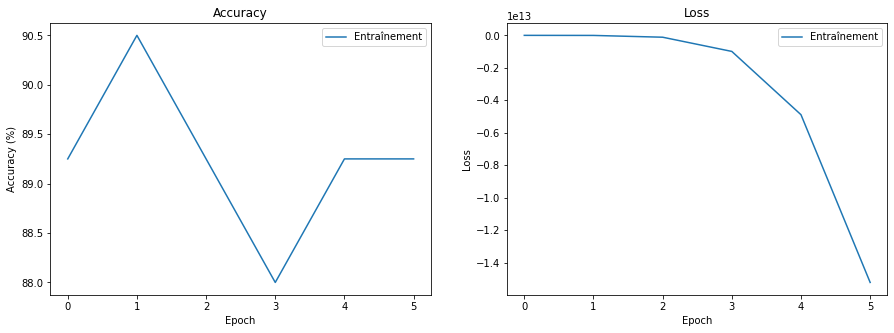

In [13]:
plot_learning_curves(history)


In [16]:
model.save(MODEL_PATH+"/convolution.h5")

In [2]:
model = tf.keras.load_model("convultion.h5")

NameError: ignored

In [17]:
for (im, lab) in train_ds.take(3):
  print(im)
  print(model.predict(im))

tf.Tensor(
[[[[119. 146. 193.]
   [119. 146. 193.]
   [119. 146. 193.]
   ...
   [120. 148. 197.]
   [120. 148. 197.]
   [120. 148. 197.]]

  [[119. 146. 193.]
   [119. 146. 193.]
   [119. 146. 193.]
   ...
   [120. 148. 197.]
   [120. 148. 197.]
   [120. 148. 197.]]

  [[119. 146. 193.]
   [119. 146. 193.]
   [119. 146. 193.]
   ...
   [120. 148. 197.]
   [120. 148. 197.]
   [120. 148. 197.]]

  ...

  [[208. 202. 210.]
   [208. 203. 210.]
   [209. 203. 210.]
   ...
   [221. 215. 219.]
   [220. 214. 218.]
   [220. 214. 218.]]

  [[209. 204. 210.]
   [210. 204. 211.]
   [210. 204. 211.]
   ...
   [222. 216. 220.]
   [222. 216. 219.]
   [222. 215. 219.]]

  [[210. 204. 211.]
   [210. 204. 211.]
   [209. 203. 210.]
   ...
   [223. 217. 221.]
   [223. 217. 220.]
   [223. 216. 220.]]]


 [[[120. 146. 193.]
   [120. 146. 193.]
   [119. 146. 193.]
   ...
   [120. 148. 197.]
   [120. 148. 197.]
   [120. 148. 197.]]

  [[120. 146. 193.]
   [120. 146. 193.]
   [120. 146. 193.]
   ...
   [120. 1